# Lokalizacja punktu w przestrzeni dwuwymiarowej – metoda trapezowa 

## Wprowadzenie do problemu lokalizacji punktu na płaszczyźnie
### Dane:
Poligonowy podział płaszczyzny (tzw. podział planarny) $S$. Należy go przetworzyć (zapisując wyniki w odpowiedniej strukturze
danych) tak, aby umożliwić efektywne osiągnięcie celu.
### Cel:
Odszukanie wielokąta (ściany) zawierającego zadany punkt.

Możliwa jest sytuacja, że zadany punkt nie leży wewnątrz żadnej ze ścian. Aby uwzględnić taki przypadek, umieszczamy nasz podział w odpowiednio dużym prostokącie $R$. Wtedy w razie takiej sytuacji wskażemy obszar wyznaczony przez ten prostokąt.

## Metoda trapezowa
W przypadku podejścia do rozwiązania przedstawionego powyżej problemu metodą trapezową, podział płaszczyzny będzie reprezentowany przez zbiór odcinków $S$={$s$<sub>1</sub>,$s$<sub>2</sub>,...,$s$<sub>n</sub>}. Poczynione założenia:
- odcinki nie przecinają się, poza ewentualnie wierzchołkami
- żaden odcinek nie jest pionowy
- wierzchołki żadnych dwóch odcinków nie mają takiej samej współrzędnej x (poza końcami połączonych odcinków)

Drugie i trzecie założenie wskazują na to, że zbiór odcinków $S$ jest w położeniu ogólnym.

### Mapa trapezowa
Mapa trapezowa $T$($S$) jest podziałem $S$ na wielokąty wypukłe (trapezy lub trójkąty; będziemy je nazywać *trapezami*, traktując trójkąt jako zdegenerowany trapez, w którym jeden z boków zredukował się do zera) otrzymanym przez poprowadzenie dwóch rozszerzeń (odcinków) pionowych z każdego końca odcinka w $S$. Rozszerzenia kończą się, gdy napotkają inny odcinek $S$ lub
brzeg prostokąta (ramki) $R$. 

## Struktury używane w ramach algorytmu

In [1]:
#pojedynczy element mapy trapezowej
class Trapezoid:
    def __init__(self,upper,lower,left,right):
        self.upper=upper #niepionowy odcinek z S / górna krawędź ramki R, ograniczająca trapez z góry
        self.lower=lower #niepionowy odcinek z S / dolna krawędź ramki R, ograniczająca trapez od dołu
        self.left_p=left #punkt końcowy definiujący lewą krawędź trapezu
        self.right_p=right #punkt końcowy definiujący prawą krawędź trapezu
        self.right_upper_neighbour=None #prawy górny sąsiad trapezu w mapie trapezowej
        self.right_lower_neighbour=None #prawy dolny sąsiad trapezu w mapie trapezowej
        self.left_lower_neighbour=None #lewy dolny sąsiad trapezu w mapie trapezowej
        self.left_upper_neighbour=None #lewy górny sąsiad trapezu w mapie trapezowej
        self.leaf=None #wskaźnik do liścia w strukturze przeszukiwań
        
    def __repr__(self):
        part1="Trapezoid\nupper: "+str(self.upper)+"\nlower: "+str(self.lower)+"\nleft: "+str(self.left_p)
        part2="\nright: "+str(self.right_p)+"\nleaf: "+str(self.leaf)+"\n\n"
        return part1+part2

#struktura przeszukiwań - drzewo i węzły
class DTree:
    def __init__(self,root):
        self.root=root #korzeń drzewa przeszukiwań
        
class DNode:
    def __init__(self,kind,label):
        self.kind=kind #rodzaj węzła - x-węzeł (0), y-węzeł (1) albo liść (2)
        self.label=label #etykieta węzła - w zależności od typu węzła jest to punkt, odcinek albo trapez
        self.left=None #punkt po lewej stronie (x-węzeł), odcinek leżący powyżej (y-węzeł)
        self.right=None #punkt po prawej stronie (x-węzeł), odcinek leżący poniżej (y-węzeł)
        
    def __str__(self):
        return "kind: "+str(self.kind)+", label:"+str(self.label.__class__)

#klasa reprezentująca punkt
class Point:
    def __init__(self,x,y):
        self.x=x #współrzędna x-owa
        self.y=y #współrzędna y-owa
        
    def __eq__(self,other):
        return self.x==other.x and self.y==other.y
    
    def __gt__(self,other):
        return self.x>other.x
    
    def __hash__(self):
        return hash((self.x,self.y))
    
    def __str__(self):
        return "x="+str(self.x)+", y="+str(self.y)
    
#klasa reprezentująca odcinek
class Section:
    def __init__(self,L,R):
        self.L=L #lewy koniec odcinka
        self.R=R #prawy koniec odcinka
        if self.R.x!=self.L.x:
            self.a=(self.R.y-self.L.y)/(self.R.x-self.L.x) #współczynnik nachylenia
        else:
            self.a=None
        if self.a!=None:
            self.b=self.L.y-self.a*self.L.x #wyraz wolny
        else:
            self.b=None
        self.x=L.x
        
    def update_x(x): 
        Section.x=x
    
    def __gt__(self,other):
        return self.a*Section.x+self.b>other.a*Section.x+other.b
    
    def __hash__(self):
        return hash((self.L,self.R))
    
    def __str__(self):
        return "Left point: "+str(self.L)+"\nRight point: "+str(self.R)
    
    def above_point(self,point):
        return self.a*Section.x+self.b>point.y
    
    def at_x(self):
        return Point(Section.x,self.a*Section.x+self.b)

##### Spostrzeżenie:
Nie ma potrzeby tworzyć struktury dla "całej" mapy trapezowej, ponieważ potrzebne informacje uzyskamy ze struktury przeszukiwań.
### Pomocnicze biblioteki

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from bitalg.visualizer.main import Visualizer

## Algorytmy potrzebne do rozwiązania problemu
### Randomizowany algorytm przyrostowy
Ideą tego algorytmu jest to, że przetwarzamy odcinki ze zbioru $S$ w losowej kolejności (bierzemy dowolną permutację). Dla pewnych przypadków otrzymana struktura przeszukiwań $D$ ma rozmiar kwadratowy i liniowy czas przeszukiwania, ale dla innych permutacji złożoności tych operacji będą dużo lepsze. Analiza złożoności tego algorytmu jest probabilistyczna. Jak się okazuje, oczekiwana złożoność czasowa konstrukcji mapy trapezowej to ```O(nlogn)```, oczekiwany rozmiar struktury przeszukiwań to ```O(n)```, natomiast oczekiwany czas zapytania dla dowolnego punktu to ```O(logn)```, gdzie *n* oznacza liczbę odcinków ze zbioru $S$, dla którego tę strukturę przygotowujemy.
#### Główna funkcja

In [3]:
def trapezoidal_map(S):
    """
    Funkcja wyznacza mapę trapezową T(S) oraz strukturę przeszukiwań D dla zadanego zbioru odcinków S.
    :param S: zbiór odcinków spełniających założenia wspomniane powyżej
    :return: mapa trapezowa T(S), struktura przeszukiwań D dla tej mapy trapezowej oraz ramka R zawierająca odcinki
    """
    lower_left,upper_right=find_boundaries(S)
    upper=Section(Point(lower_left.x,upper_right.y),upper_right)
    lower=Section(lower_left,Point(upper_right.x,lower_left.y))
    R=Trapezoid(upper,lower,lower_left,upper_right)
    T=R
    root=DNode(2,T)
    T.leaf=root
    D=DTree(root)
    sections=np.random.permutation(S)
    n=len(S)
    vis=draw_map(D,R)
    vis.show()
    for i in range(n):
        intersected_trapezoids=follow_segment(T,D,sections[i],R)
        if len(intersected_trapezoids)==1:
            update_structures_one(T,D,intersected_trapezoids[0],sections[i])
        else:
            update_structures_many(T,D,intersected_trapezoids,sections[i])
        vis=draw_map(D,R)
        vis.show()
    return T,D,R

Poniżej znajdują się pomocnicze funkcje do ```trapezoidal_map```, również bardzo istotne na drodze do rozwiązania problemu. Funkcje aktualizujące struktury zostały rozdzielone z powodu bardzo długiego kodu, aby były bardziej czytelne.

In [4]:
def find_boundaries(S):
    """
    Funkcja wyznacza krańcowe punkty ramki R (lewy dolny i prawy górny punkt).
    :param S: zbiór odcinków, dla którego wyznaczamy granice ramki
    :return: lewy dolny i prawy górny punkt ramki R
    """
    x_left=S[0].L.x
    y_left=min(S[0].L.y,S[0].R.y)
    x_right=S[0].R.x
    y_right=max(S[0].L.y,S[0].R.y)
    n=len(S)
    for i in range(1,n):
        left=S[i].L
        right=S[i].R
        x_left=min(x_left,left.x)
        y_left=min(y_left,left.y,right.y)
        x_right=max(x_right,right.x)
        y_right=max(y_right,left.y,right.y)
    return Point(x_left,y_left),Point(x_right,y_right)

In [5]:
def follow_segment(T,D,s,R):
    """
    Funkcja wyznacza ciąg trapezów w mapie trapezowej T przeciętych przez odcinek s,
    wykorzystując w tym celu strukturę przeszukiwań D.
    :param T: mapa trapezowa dla odcinków występujących przed właśnie sprawdzanym odcinkiem s
    :param D: prawidłowa struktura przeszukiwań dla aktualnej mapy trapezowej T
    :param s: odcinek ze zbioru S, który jest właśnie uwzględniany w strukturach
    :param R: ramka dla zbioru odcinków S
    """
    p,q=s.L,s.R
    vis=Visualizer()
    trapezoids=[]
    Section.update_x(p.x)
    trapezoid_zero=search_trapezoid(D.root,p,s)
    trapezoids.append(trapezoid_zero)
    j=0
    vis,neighbours=draw_trapezoid_with_neighbours(trapezoids[j],vis,[])
    vis.add_line_segment(section_to_tuple(s),color="red")
    vis=draw_grid(R,vis)
    vis.show()
    while q>trapezoids[j].right_p:
        Section.update_x(trapezoids[j].right_p.x)
        if s.above_point(trapezoids[j].right_p):
            trapezoids.append(trapezoids[j].right_upper_neighbour)
        else:
            trapezoids.append(trapezoids[j].right_lower_neighbour)
        j+=1
        vis,neighbours=draw_trapezoid_with_neighbours(trapezoids[j],vis,neighbours)
        vis.show()
    return trapezoids

In [6]:
def search_trapezoid(node,point,segment=None):
    """
    Funkcja znajduje pierwszy (z lewej) trapez, który zawiera w sobie szukany punkt. Jeżeli punkt leży na 
    odcinku pionowym łączącym dwa trapezy, uznajemy, że należy do "prawego" trapezu. Z kolei gdy punkt leży 
    na już wcześniej uwzględnionym odcinku, porównujemy nachylenia: już dodanego odcinka s1 i właśnie badanego
    odcinka s2. Jeżeli s2 ma większe nachylenie, to przyjmujemy, że punkt leży powyżej s1 i vice-versa.
    :param node: węzęł drzewa przeszukiwań; początkowo jest to korzeń drzewa
    :param point: punkt, dla którego szukamy trapezu
    :param segment: właśnie badany odcinek (w trakcie tworzenia mapy trapezowej)
    :return: trapez zawierający szukany punkt
    """
    if node.kind==2:
        return node.label
    elif node.kind==0:
        if point<node.label:
            return search_trapezoid(node.left,point,segment)
        else:
            return search_trapezoid(node.right,point,segment)
    else:
        if node.label.above_point(point):
            return search_trapezoid(node.right,point,segment)
        elif node.label.at_x()==point:
            if segment.a>node.label.a:
                return search_trapezoid(node.left,point,segment)
            else:
                return search_trapezoid(node.right,point,segment)
        else:
            return search_trapezoid(node.left,point,segment)

In [7]:
def update_structures_one(T,D,trapezoid,s):
    """
    Funkcja aktualizuje mapę trapezową T oraz strukturę przeszukiwań D, usuwając wskazany trapez i konstruując nowe.
    :param T: mapa trapezowa dla odcinków występujących przed właśnie sprawdzanym odcinkiem s
    :param D: prawidłowa struktura przeszukiwań dla aktualnej mapy trapezowej T
    :param trapezoid: trapez zawierający odcinek s, ma on być usunięty i zastąpiony
    :param s: odcinek ze zbioru S, który jest właśnie uwzględniany w strukturach
    """
    p,q=s.L,s.R
    A,B=None,None #left right
    left_lower_neighbour=trapezoid.left_lower_neighbour
    left_upper_neighbour=trapezoid.left_upper_neighbour
    right_upper_neighbour=trapezoid.right_upper_neighbour
    right_lower_neighbour=trapezoid.right_lower_neighbour
    node=trapezoid.leaf
    if trapezoid.left_p<p:
        A=Trapezoid(trapezoid.upper,trapezoid.lower,trapezoid.left_p,p)
        A.left_lower_neighbour=left_lower_neighbour
        A.left_upper_neighbour=left_upper_neighbour
        if left_lower_neighbour:
            left_lower_neighbour.right_lower_neighbour=A
        if left_upper_neighbour:
            left_upper_neighbour.right_upper_neighbour=A
    C=Trapezoid(trapezoid.upper,s,p,q)
    D=Trapezoid(s,trapezoid.lower,p,q)
    if A:
        C.left_upper_neighbour=A
        D.left_lower_neighbour=A
        A.right_upper_neighbour=C
        A.right_lower_neighbour=D
    else:
        Section.update_x(p.x)
        D.left_lower_neighbour=left_lower_neighbour
        C.left_upper_neighbour=left_upper_neighbour
        if left_lower_neighbour:
            left_lower_neighbour.right_lower_neighbour=D
            if left_lower_neighbour.upper>s:
                left_lower_neighbour.right_upper_neighbour=C
                C.left_lower_neighbour=left_lower_neighbour
        if left_upper_neighbour:
            left_upper_neighbour.right_upper_neighbour=C
            if s>left_upper_neighbour.lower:
                left_upper_neighbour.right_lower_neighbour=D
                D.left_upper_neighbour=left_upper_neighbour
    if trapezoid.right_p>q:
        B=Trapezoid(trapezoid.upper,trapezoid.lower,q,trapezoid.right_p)
        B.right_lower_neighbour=right_lower_neighbour
        B.right_upper_neighbour=right_upper_neighbour
        B.left_lower_neighbour=D
        B.left_upper_neighbour=C
        C.right_upper_neighbour=B
        D.right_lower_neighbour=B
        if right_lower_neighbour:
            right_lower_neighbour.left_lower_neighbour=B
        if right_upper_neighbour:
            right_upper_neighbour.left_upper_neighbour=B
    else:
        Section.update_x(q.x)
        D.right_lower_neighbour=right_lower_neighbour
        C.right_upper_neighbour=right_upper_neighbour
        if right_lower_neighbour:
            right_lower_neighbour.left_lower_neighbour=D
            if right_lower_neighbour.upper>s:
                right_lower_neighbour.left_upper_neighbour=C
                C.right_lower_neighbour=right_lower_neighbour
        if right_upper_neighbour:
            right_upper_neighbour.left_upper_neighbour=C
            if s>right_upper_neighbour.lower:
                right_upper_neighbour.left_lower_neighbour=D
                D.right_upper_neighbour=right_upper_neighbour
    if A and B:
        node.kind=0
        node.label=p
        left=DNode(2,A)
        node.left=left
        A.leaf=left
        right=DNode(0,q)
        node.right=right
        right_right=DNode(2,B)
        right.right=right_right
        B.leaf=right_right
        right_left=DNode(1,s)
        right.left=right_left
        right_left_left=DNode(2,C)
        right_left.left=right_left_left
        C.leaf=right_left_left
        right_left_right=DNode(2,D)
        right_left.right=right_left_right
        D.leaf=right_left_right
    elif not A and B:
        node.kind=0
        node.label=q
        right=DNode(2,B)
        node.right=right
        B.leaf=right
        left=DNode(1,s)
        node.left=left
        left_left=DNode(2,C)
        left.left=left_left
        C.leaf=left_left
        left_right=DNode(2,D)
        left.right=left_right
        D.leaf=left_right
    elif A and not B:
        node.kind=0
        node.label=p
        left=DNode(2,A)
        node.left=left
        A.leaf=left
        right=DNode(1,s)
        node.right=right
        right_right=DNode(2,D)
        right.right=right_right
        D.leaf=right_right
        right_left=DNode(2,C)
        right.left=right_left
        C.leaf=right_left
    else:
        node.kind=1
        node.label=s
        left=DNode(2,C)
        node.left=left
        C.leaf=left
        right=DNode(2,D)
        node.right=right
        D.leaf=right

In [8]:
def update_structures_many(T,D,trapezoids,s):
    """
    Funkcja aktualizuje mapę trapezową T oraz strukturę przeszukiwań D, usuwając odpowiednie trapezy i konstruując nowe.
    :param T: mapa trapezowa dla odcinków występujących przed właśnie sprawdzanym odcinkiem s
    :param D: prawidłowa struktura przeszukiwań dla aktualnej mapy trapezowej T
    :param trapezoids: lista trapezów przeciętych przez odcinek s, mają one być usunięte i zastąpione
    :param s: odcinek ze zbioru S, który jest właśnie uwzględniany w strukturach
    """
    p,q=s.L,s.R
    A,D=None,None
    new_trapezoids_above=[]
    new_trapezoids_below=[]
    n=len(trapezoids)
    first=trapezoids[0]
    left_lower_neighbour=first.left_lower_neighbour
    left_upper_neighbour=first.left_upper_neighbour
    right_upper_neighbour=first.right_upper_neighbour
    right_lower_neighbour=first.right_lower_neighbour
    Section.update_x(first.right_p.x)
    if s.above_point(first.right_p):
        B=Trapezoid(first.upper,s,p,s.at_x())
        C=Trapezoid(s,first.lower,p,first.right_p)
        to_merge="upper"
    else:
        B=Trapezoid(first.upper,s,p,first.right_p)
        C=Trapezoid(s,first.lower,p,s.at_x())
        to_merge="lower"
    if first.left_p<p:
        A=Trapezoid(first.upper,first.lower,first.left_p,p)
        A.left_lower_neighbour=left_lower_neighbour
        A.left_upper_neighbour=left_upper_neighbour
        A.right_upper_neighbour=B
        A.right_lower_neighbour=C
        B.left_upper_neighbour=A
        C.left_lower_neighbour=A
        if left_lower_neighbour:
            left_lower_neighbour.right_lower_neighbour=A
        if left_upper_neighbour:
            left_upper_neighbour.right_upper_neighbour=A    
    else:
        B.left_upper_neighbour=left_upper_neighbour
        C.left_lower_neighbour=left_lower_neighbour
        if left_lower_neighbour:
            left_lower_neighbour.right_lower_neighbour=C
            if left_lower_neighbour.upper>s:
                left_lower_neighbour.right_upper_neighbour=B
                B.left_lower_neighbour=left_lower_neighbour
        if left_upper_neighbour:
            left_upper_neighbour.right_upper_neighbour=B
            if s>left_upper_neighbour.lower:
                left_upper_neighbour.right_lower_neighbour=C
                C.left_upper_neighbour=left_upper_neighbour
    if trapezoids[1]==first.right_lower_neighbour:
        B.right_upper_neighbour=right_upper_neighbour
        if right_upper_neighbour:
            right_upper_neighbour.left_upper_neighbour=B
    else:
        C.right_lower_neighbour=right_lower_neighbour
        if right_lower_neighbour:
            right_lower_neighbour.left_lower_neighbour=C
    new_trapezoids_above.append(B)
    new_trapezoids_below.append(C)
    for j in range(1,n-1):
        next_point=trapezoids[j].right_p
        left_lower_neighbour=trapezoids[j].left_lower_neighbour
        left_upper_neighbour=trapezoids[j].left_upper_neighbour
        right_upper_neighbour=trapezoids[j].right_upper_neighbour
        right_lower_neighbour=trapezoids[j].right_lower_neighbour
        Section.update_x(next_point.x)
        if s.above_point(next_point):
            upper_right_point=s.at_x()
            if to_merge=="upper":
                B.right_p=upper_right_point
                t=Trapezoid(s,trapezoids[j].lower,C.right_p,next_point)
                C.right_upper_neighbour=t
                t.left_upper_neighbour=C
                t.left_lower_neighbour=left_lower_neighbour
                t.right_lower_neighbour=right_lower_neighbour
                if left_lower_neighbour:
                    left_lower_neighbour.right_lower_neighbour=t
                if right_lower_neighbour:
                    right_lower_neighbour.left_lower_neighbour=t
                C=t
                new_trapezoids_below.append(C)
            else:
                C.right_p=next_point
                t=Trapezoid(trapezoids[j].upper,s,B.right_p,upper_right_point)
                B.right_lower_neighbour=t
                t.left_lower_neighbour=B
                t.left_upper_neighbour=left_upper_neighbour
                if left_upper_neighbour:
                    left_upper_neighbour.right_upper_neighbour=t
                C.right_lower_neighbour=right_lower_neighbour
                if right_lower_neighbour:
                    right_lower_neighbour.left_lower_neighbour=C
                B=t
                new_trapezoids_above.append(B)
            to_merge="upper"
        else:
            lower_right_point=s.at_x()
            if to_merge=="upper":
                B.right_p=next_point
                t=Trapezoid(s,trapezoids[j].lower,C.right_p,lower_right_point)
                C.right_upper_neighbour=t
                t.left_upper_neighbour=C
                t.left_lower_neighbour=left_lower_neighbour
                if left_lower_neighbour:
                    left_lower_neighbour.right_lower_neighbour=t
                B.right_upper_neighbour=right_upper_neighbour
                if right_upper_neighbour:
                    right_upper_neighbour.left_upper_neighbour=B
                C=t
                new_trapezoids_below.append(C)
            else:
                C.right_p=lower_right_point
                t=Trapezoid(trapezoids[j].upper,s,B.right_p,next_point)
                B.right_lower_neighbour=t
                t.left_lower_neighbour=B
                t.left_upper_neighbour=left_upper_neighbour
                t.right_upper_neighbour=right_upper_neighbour
                if left_upper_neighbour:
                    left_upper_neighbour.right_upper_neighbour=t
                if right_upper_neighbour:
                    right_upper_neighbour.left_upper_neighbour=t
                B=t
                new_trapezoids_above.append(B)
            to_merge="lower"
    last=trapezoids[n-1]
    left_lower_neighbour=last.left_lower_neighbour
    left_upper_neighbour=last.left_upper_neighbour
    right_upper_neighbour=last.right_upper_neighbour
    right_lower_neighbour=last.right_lower_neighbour
    if to_merge=="upper":
        B.right_p=q
        t=Trapezoid(s,last.lower,C.right_p,q)
        C.right_upper_neighbour=t
        t.left_upper_neighbour=C
        C=t
        new_trapezoids_below.append(C)
    else:
        C.right_p=q
        t=Trapezoid(last.upper,s,B.right_p,q)
        B.right_lower_neighbour=t
        t.left_lower_neighbour=B
        B=t
        new_trapezoids_above.append(B)
    if last.right_p>q:
        D=Trapezoid(last.upper,last.lower,q,last.right_p)
        D.left_lower_neighbour=C
        D.left_upper_neighbour=B
        D.right_upper_neighbour=right_upper_neighbour
        D.right_lower_neighbour=right_lower_neighbour
        B.right_upper_neighbour=D
        C.right_lower_neighbour=D
        if right_lower_neighbour:
            right_lower_neighbour.left_lower_neighbour=D
        if right_upper_neighbour:
            right_upper_neighbour.left_upper_neighbour=D
    else:
        B.right_upper_neighbour=right_upper_neighbour
        C.right_lower_neighbour=right_lower_neighbour
        if right_lower_neighbour:
            right_lower_neighbour.left_lower_neighbour=C
            if right_lower_neighbour.upper>s:
                right_lower_neighbour.left_upper_neighbour=B
                B.right_lower_neighbour=right_lower_neighbour
        if right_upper_neighbour:
            right_upper_neighbour.left_upper_neighbour=B
            if s>right_upper_neighbour.lower:
                right_upper_neighbour.left_lower_neighbour=C
                C.right_upper_neighbour=right_upper_neighbour
    if trapezoids[n-1]==trapezoids[n-2].right_upper_neighbour:
        C.left_lower_neighbour=left_lower_neighbour
        if left_lower_neighbour:
            left_lower_neighbour.right_lower_neighbour=C
    else:
        B.left_upper_neighbour=left_upper_neighbour
        if left_upper_neighbour:
            left_upper_neighbour.right_upper_neighbour=B
    far_left=first.leaf
    if A:
        far_left.kind=0
        far_left.label=p
        left=DNode(2,A)
        far_left.left=left
        A.leaf=left
        right=DNode(1,s)
        far_left.right=right
        right_left=DNode(2,new_trapezoids_above[0])
        right.left=right_left
        new_trapezoids_above[0].leaf=right_left
        right_right=DNode(2,new_trapezoids_below[0])
        right.right=right_right
        new_trapezoids_below[0].leaf=right_right
    else:
        far_left.kind=1
        far_left.label=s
        left=DNode(2,new_trapezoids_above[0])
        far_left.left=left
        new_trapezoids_above[0].leaf=left
        right=DNode(2,new_trapezoids_below[0])
        far_left.right=right
        new_trapezoids_below[0].leaf=right
    i=0
    j=0
    k=len(new_trapezoids_above)
    m=len(new_trapezoids_below)
    while i+j<n-2:
        node=trapezoids[i+j+1].leaf
        node.kind=1
        node.label=s
        if new_trapezoids_above[i].right_p>new_trapezoids_below[j].right_p or i==k-1:
            j+=1
            left=new_trapezoids_above[i].leaf
            node.left=left
            right=DNode(2,new_trapezoids_below[j])
            node.right=right
            new_trapezoids_below[j].leaf=right
        else:
            i+=1
            left=DNode(2,new_trapezoids_above[i])
            node.left=left
            new_trapezoids_above[i].leaf=left
            right=new_trapezoids_below[j].leaf
            node.right=right
    far_right=last.leaf
    if D:
        far_right.kind=0
        far_right.label=q
        right=DNode(2,D)
        far_right.right=right
        D.leaf=right
        left=DNode(1,s)
        far_right.left=left
        if i==k-1 and j==m-1:
            left.left=new_trapezoids_above[i].leaf
            left.right=new_trapezoids_below[j].leaf
        elif j==m-1:
            left_left=DNode(2,new_trapezoids_above[-1])
            left.left=left_left
            new_trapezoids_above[-1].leaf=left_left
            left.right=new_trapezoids_below[j].leaf
        else:
            left_right=DNode(2,new_trapezoids_below[-1])
            left.right=left_right
            new_trapezoids_below[-1].leaf=left_right
            left.left=new_trapezoids_above[i].leaf
    else:
        far_right.kind=1
        far_right.label=s
        if i==k-1 and j==m-1:
            far_right.left=new_trapezoids_above[i].leaf
            far_right.right=new_trapezoids_below[j].leaf
        elif j==m-1:
            left=DNode(2,new_trapezoids_above[-1])
            far_right.left=left
            new_trapezoids_above[-1].leaf=left
            far_right.right=new_trapezoids_below[j].leaf
        else:
            right=DNode(2,new_trapezoids_below[-1])
            far_right.right=right
            new_trapezoids_below[-1].leaf=right
            far_right.left=new_trapezoids_above[i].leaf

Poniżej znajduje się funkcja przedstawiająca graficznie punkt wraz z trapezem, który go zawiera oraz funkcje pomocnicze do niej.

In [9]:
def draw_trapezoid_and_point(point,D,R):
    """
    Funkcja zwraca wizualizer, wyświetlający podany punkt oraz boki znalezionego trapezu, zawierającego punkt.
    :param point: punkt, dla którego szukamy trapezu
    :param D: struktura przeszukiwań dla mapy trapezowej
    :param R: ramka zawierająca wszystkie odcinki
    :return: wizualizer zawierający dodane odpowiednie odcinki i punkty
    """
    vis=Visualizer()
    vis.add_point((point.x,point.y),color="red")
    Section.update_x(point.x)
    root=D.root
    trapezoid=search_trapezoid(root,point)
    vis=draw_trapezoid(trapezoid,vis)
    vis=draw_grid(R,vis)             
    return vis

In [10]:
def draw_grid(R,vis):
    """
    Funkcja rysuje ramkę (prostokąt zewnętrzny) dla mapy trapezowej, dodając odpowiednie boki do wizualizera.
    :param R: ramka dla mapy trapezowej
    :param vis: wizualizer, do którego dodajemy odpowiednie boki
    :return: wizualizer z dodanymi bokami prostokąta
    """
    vis.add_line_segment((section_to_tuple(R.upper),section_to_tuple(R.lower)),color="brown")
    R_left=Section(R.left_p,Point(R.left_p.x,R.right_p.y))
    R_right=Section(Point(R.right_p.x,R.left_p.y),R.right_p)
    vis.add_line_segment((section_to_tuple(R_left),section_to_tuple(R_right)),color="brown")
    return vis

In [11]:
def draw_trapezoid(trapezoid,vis,color="green"):
    """
    Funkcja rysuje wskazany trapez.
    :param trapezoid: trapez, który ma być narysowany
    :param vis: wizualizer, do którego dodajemy elementy charakterystyczne trapezu
    :param color: kolor, jakim ma być wyróżniony trapez
    :return: wizualizer z dodanymi odpowiednimi elementami wyznaczającymi trapez
    """
    vis.add_point(((trapezoid.left_p.x,trapezoid.left_p.y),(trapezoid.right_p.x,trapezoid.right_p.y)),color="blue")
    upper=section_to_tuple(trapezoid.upper)
    lower=section_to_tuple(trapezoid.lower)
    left_x=trapezoid.left_p.x
    Section.update_x(left_x)
    left_lower=trapezoid.lower.at_x()
    left_upper=trapezoid.upper.at_x()
    left_vertical=(section_to_tuple(Section(left_lower,left_upper)))
    right_x=trapezoid.right_p.x
    Section.update_x(right_x)
    right_lower=trapezoid.lower.at_x()
    right_upper=trapezoid.upper.at_x()
    right_vertical=(section_to_tuple(Section(right_lower,right_upper)))
    vis.add_line_segment((upper,lower,left_vertical,right_vertical),color=color)
    return vis

In [12]:
def draw_trapezoid_with_neighbours(trapezoid,vis,neighbours):
    """
    Funkcja rysuje wskazany trapez, wyróżniając jego sąsiadów.
    :param trapezoid: trapez, który ma być narysowany
    :param vis: wizualizer, do którego dodajemy elementy charakterystyczne trapezu
    :param neighbours: poprzedni sąsiedzi ( do usunięcia z wizualizatora)
    :return: krotka postaci (wizualizer z dodanymi odpowiednimi elementami wyznaczającymi trapez,
    sąsiedzi tego trapezu wyróżnieni innymi kolorami)
    """
    for neighbour in neighbours:
        vis.remove_figure(neighbour)
    vis.add_point(((trapezoid.left_p.x,trapezoid.left_p.y),(trapezoid.right_p.x,trapezoid.right_p.y)),color="blue")
    upper=section_to_tuple(trapezoid.upper)
    lower=section_to_tuple(trapezoid.lower)
    left_x=trapezoid.left_p.x
    Section.update_x(left_x)
    left_lower=trapezoid.lower.at_x()
    left_upper=trapezoid.upper.at_x()
    left_vertical=(section_to_tuple(Section(left_lower,left_upper)))
    right_x=trapezoid.right_p.x
    Section.update_x(right_x)
    right_lower=trapezoid.lower.at_x()
    right_upper=trapezoid.upper.at_x()
    right_vertical=(section_to_tuple(Section(right_lower,right_upper)))
    vis.add_line_segment((upper,lower,left_vertical,right_vertical),color="green")
    neighbours_to_delete=[]
    if trapezoid.left_upper_neighbour:
        neighbours_to_delete.append(draw_trapezoid(trapezoid.left_upper_neighbour,vis,"orange"))
    if trapezoid.left_lower_neighbour:
        neighbours_to_delete.append(draw_trapezoid(trapezoid.left_lower_neighbour,vis,"yellow"))
    if trapezoid.right_lower_neighbour:
        neighbours_to_delete.append(draw_trapezoid(trapezoid.right_lower_neighbour,vis,"purple"))
    if trapezoid.right_upper_neighbour:
        neighbours_to_delete.append(draw_trapezoid(trapezoid.right_upper_neighbour,vis,"cyan"))
    return vis,neighbours_to_delete

In [13]:
def section_to_tuple(section):
    """
    Funkcja przekształca obiekt klasy Segment na krotkę krotek współrzędnych.
    :param segment: odcinek jako obiekt klasy Segment
    :return: krotka krotek współrzędnych
    """
    L=section.L
    R=section.R
    return ((L.x,L.y),(R.x,R.y))

Poniżej funkcja rysująca całą mapę. Korzysta ona z pomocniczych funkcji ```draw_grid``` i ```draw_trapezoid```, użytych już wcześniej oraz funkcji pomocniczej ```find_all_trapezoids```, której kod jest w dalszej części.

In [14]:
def draw_map(D,R):
    """
    Funkcja rysuje mapę trapezową dla danej struktury przeszukiwań D.
    :param D: struktura przeszukiwań dla mapy trapezowej
    :param R: ramka dla mapy trapezowej
    :return: wizualizer z dodanymi wszystkimi elementami mapy 
    """
    vis=Visualizer()
    trapezoids=[]
    find_all_trapezoids(D.root,trapezoids)
    for trapezoid in trapezoids:
        vis=draw_trapezoid(trapezoid,vis)
    vis=draw_grid(R,vis)
    return vis

In [15]:
def find_all_trapezoids(node,trapezoids):
    """
    Funkcja znajduje wszystkie trapezy mapy trapezowej, mając korzeń drzewa przeszukiwań.
    :param node: węzeł drzewa przeszukiwań - początkowo korzeń
    :param trapezoids: lista dotychczasowo znalezionych trapezów
    """
    if node.kind==2:
        trapezoids.append(node.label)
    else:
        find_all_trapezoids(node.left,trapezoids)
        find_all_trapezoids(node.right,trapezoids)

In [19]:
%matplotlib tk

interactive_sections=[]
active=True
used_x=set()
active_points=set()
current_points=[]
last_point=None

def draw_point(point):
    """
    Funkcja rysuje punkt o współrzędnych przekazanych w argumencie.
    :param point: punkt reprezentowany przez krotkę współrzędnych x, y odczytanych z kliknięcia myszki
    """
    plt.scatter(point[0],point[1],color="red")
    plt.show()

def draw_line(points):
    """
    Funkcja rysuje odcinek między dwoma wskazanymi punktami.
    :param points: tablica punktów (krotek współrzędnych), które są końcami odcinka
    """
    ax=plt.gca()
    x=[points[0][0],points[1][0]]
    y=[points[0][1],points[1][1]]
    line=ax.plot(x,y,color="red") 
    ax.figure.canvas.draw()        

def onclick(event):
    """
    Funkcja obsługuje zdarzenie kliknięcia myszką, dodając końce odcinka
    w kliknięte miejsca lub kończąc wprowadzanie odcinków
    :param event: zdarzenie kliknięcia myszką, które przechowuje m. in. informacje 
    o klikniętym punkcie oraz to, który przycisk myszy został kliknięty
    """
    global active
    global current_points
    global last_point

    if event.dblclick and active:
        if event.button==1:
            x=event.xdata
            y=event.ydata
            if x in used_x and (x,y) not in active_points or (x,y)==last_point:
                ax.set_title("Współrzędne x-owe nie mogą się powtarzać\npoza końcami połączonych odcinków!")
                plt.pause(1.5)
                ax.set_title("Kliknij dwukrotnie, aby dodać punkt.\nKażda kolejna para punktów stworzy odcinek")
            else:
                used_x.add(x)
                active_points.add((x,y))
                last_point=(x,y)
                current_points.append((x,y))
                draw_point((x,y))
                if len(current_points)==2:
                    last_point=None
                    draw_line(current_points)
                    interactive_sections.append((current_points[0],current_points[1]))
                    current_points=[]
        elif event.button==3:
            if len(interactive_sections)<1:
                ax.set_title("Dodaj jakikolwiek odcinek!")
                plt.pause(1.5)
                ax.set_title("Kliknij dwukrotnie, aby dodać punkt.\nKażda kolejna para punktów stworzy odcinek")
            else:
                active=False
                plt.pause(0.5)
                ax.set_title("Dziękuję! Zamykam w ciągu 2 sekund")
                plt.pause(2)
                plt.close()

fig,ax=plt.subplots()
plt.get_current_fig_manager().set_window_title("Wygeneruj własny zbiór odcinków!")
ax.set_title("Kliknij dwukrotnie, aby dodać punkt.\nKażda kolejna para punktów stworzy odcinek")
connection_id=fig.canvas.mpl_connect("button_press_event",onclick)
ax.set_xlim([0,2])
ax.set_ylim([0,2])
ax.aspect=1
plt.tight_layout()
plt.ion()
plt.show()

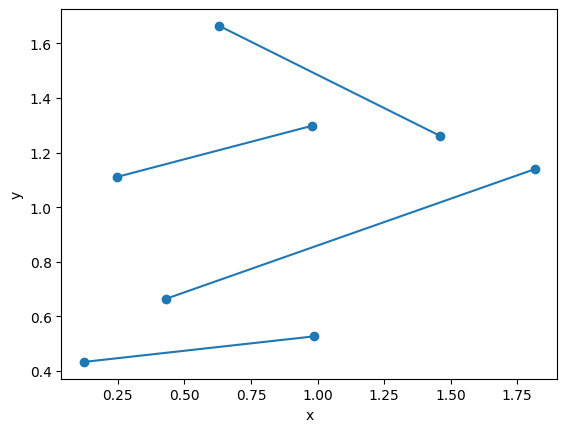

In [20]:
%matplotlib inline
vis=Visualizer()
vis.add_line_segment(interactive_sections)
vis.add_point([interactive_sections[i//2][i%2] for i in range(2*len(interactive_sections))])
vis.show()

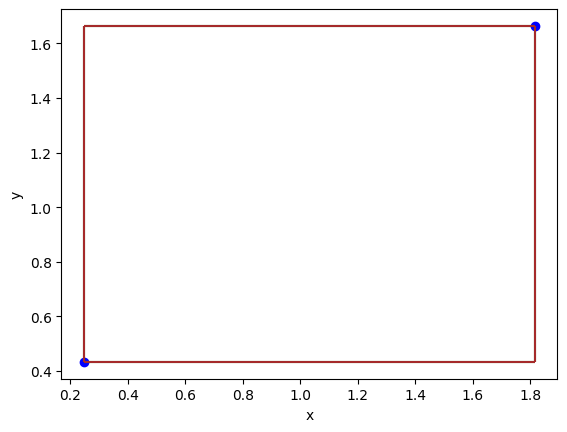

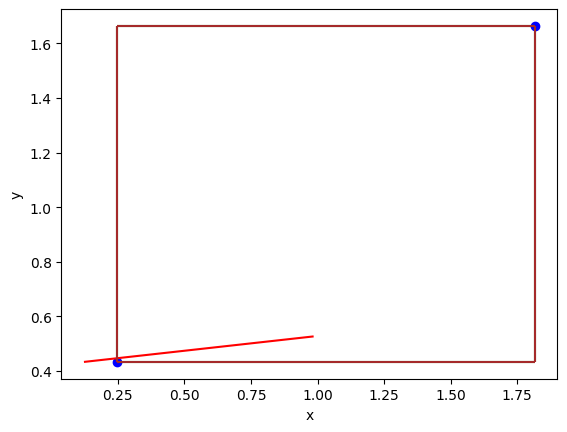

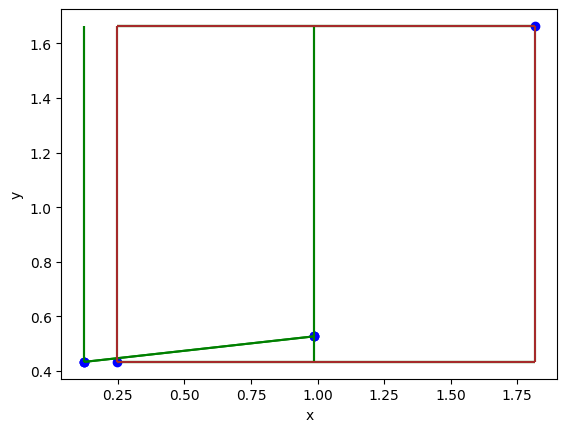

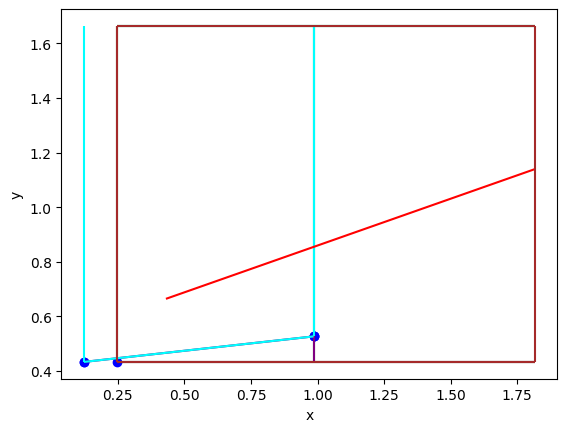

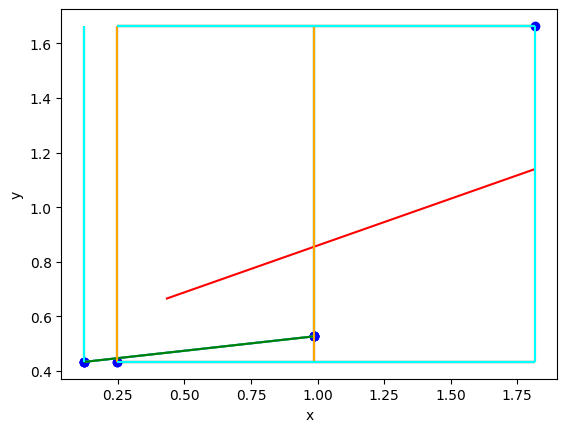

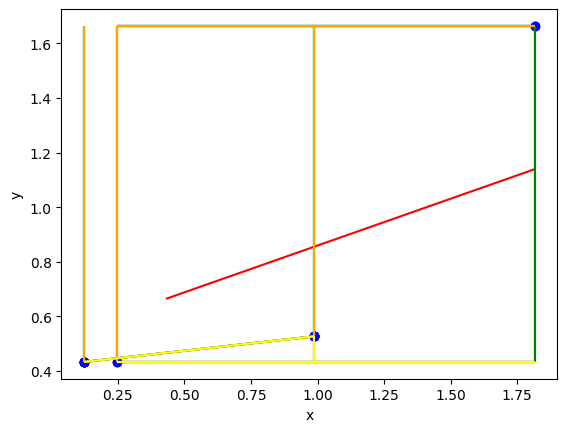

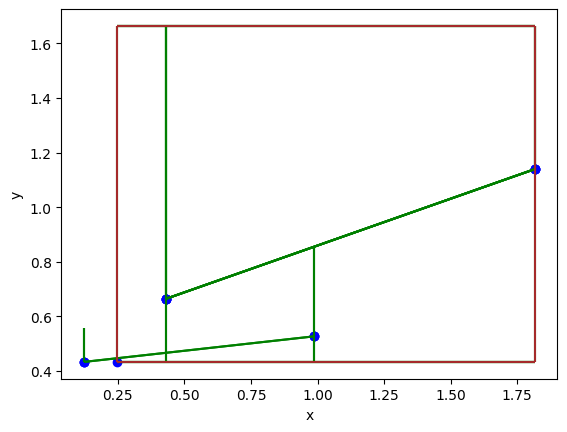

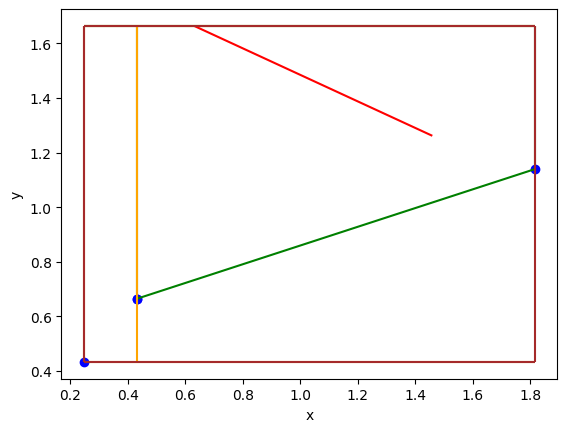

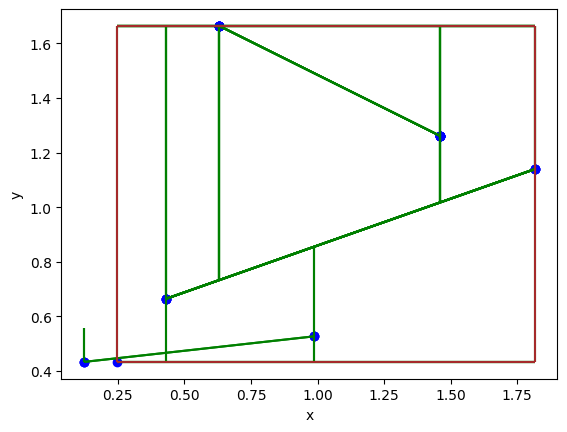

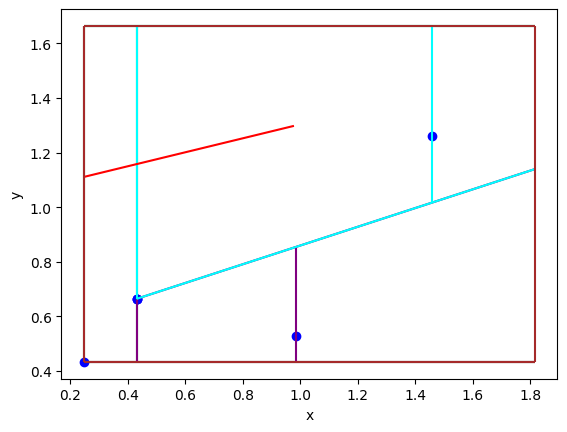

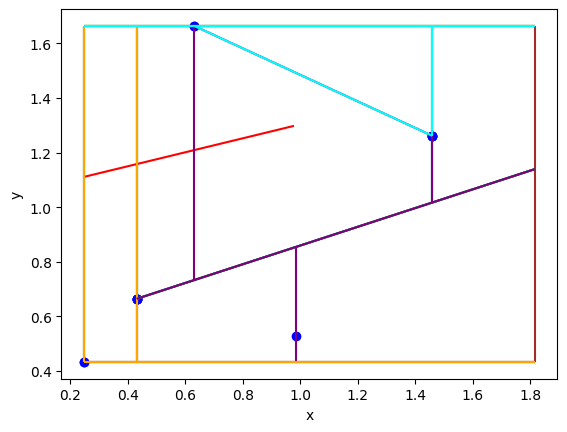

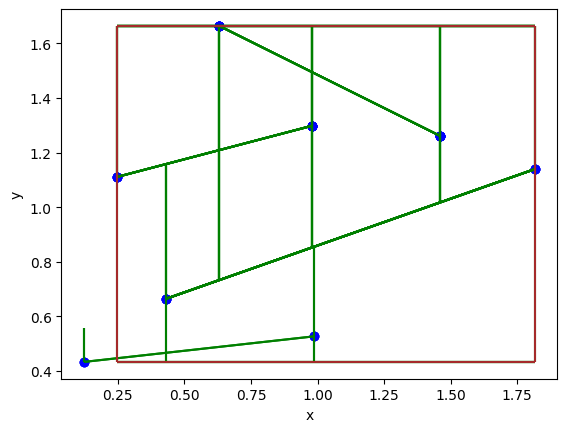

In [21]:
S=[]
n=len(interactive_sections)
for i in range(n):
    L=Point(interactive_sections[i][0][0],interactive_sections[i][0][1])
    R=Point(interactive_sections[i][1][0],interactive_sections[i][1][1])
    S.append(Section(L,R))
T,D,R=trapezoidal_map(S)

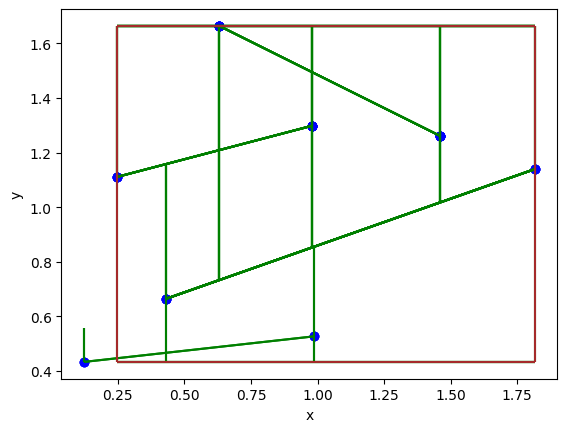

In [22]:
vis=draw_map(D,R)
vis.show()

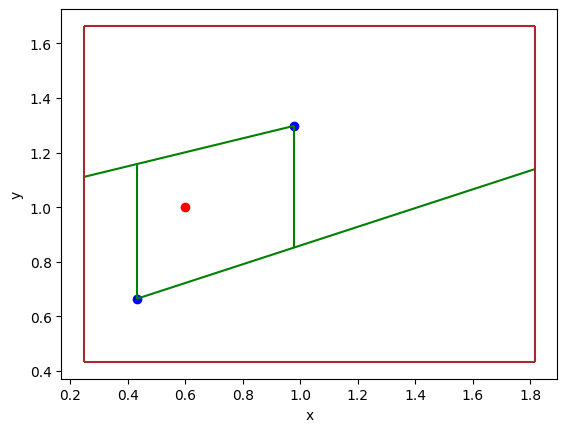

In [23]:
point=Point(0.6,1.0)
vis=draw_trapezoid_and_point(point,D,R)
vis.show()

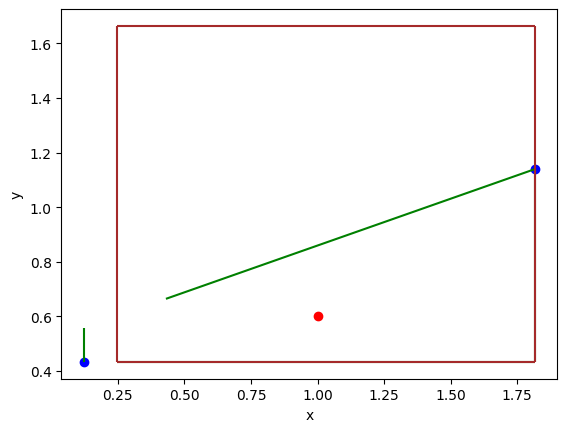

In [24]:
point=Point(1.0,0.6)
vis=draw_trapezoid_and_point(point,D,R)
vis.show()

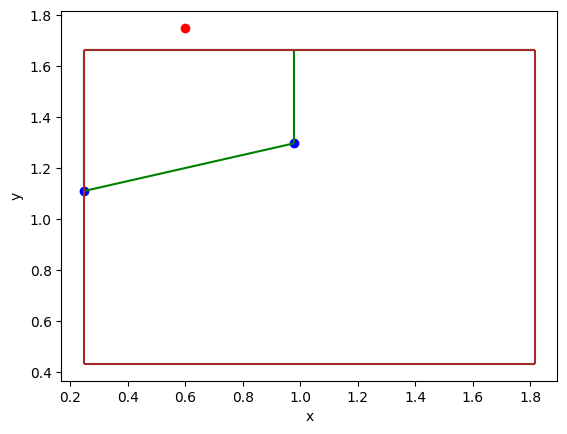

In [25]:
point=Point(0.6,1.75)
vis=draw_trapezoid_and_point(point,D,R)
vis.show()

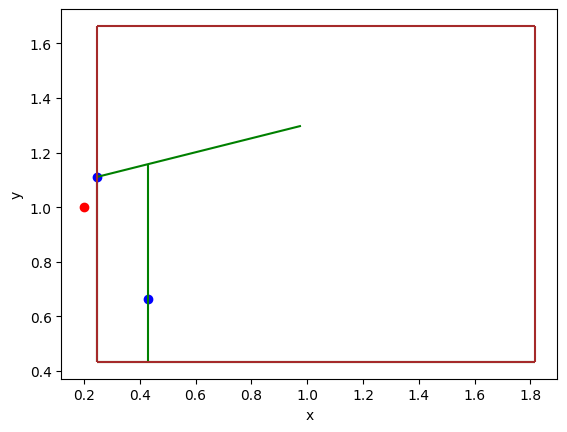

In [26]:
point=Point(0.2,1.0)
vis=draw_trapezoid_and_point(point,D,R)
vis.show()

In [ ]:
point=Point(1.25,1.5)
vis=draw_trapezoid_and_point(point,D,R)
vis.show()

In [ ]:
point=Point(1.25,0.25)
vis=draw_trapezoid_and_point(point,D,R)
vis.show()

In [ ]:
point=Point(1.65,1.2)
vis=draw_trapezoid_and_point(point,D,R)
vis.show()